In [2]:
import shap
import numpy as np
import tensorflow as tf
tf.compat.v1.disable_v2_behavior()
import pandas as pd
from sklearn import preprocessing
import joblib

Instructions for updating:
non-resource variables are not supported in the long term


In [3]:

#model=tf.keras.models.load_model(r'C:\Users\tunahan.akyol\Desktop\lstm\fcn29w16s4sentetik_10240.0003_26')
# model=tf.keras.models.load_model(r'C:\Users\tunahan.akyol\Desktop\lstm\saved_models\fcn29w16s4heading\20220317_0904\bs256_lr9e-06\models\fcn29w16s4heading_2569e-06_23')
# feature_columns=["elevation","vel", "acc","range","angularVel","radialVel","rcs"]
# df_test=pd.read_csv(r'C:\Users\tunahan.akyol\Desktop\lstm\batch_test\extractedData_All_Test.csv')
# scaler=joblib.load(r'C:\Users\tunahan.akyol\Desktop\lstm\fcn29w16s4sentetik_10240.0003_26\scaler.bin')

# df_test.loc[:, feature_columns] = scaler.transform(df_test.loc[:, feature_columns].values)
# df_test.to_csv('test_scaled_new_model.csv')

In [8]:
# model=tf.keras.models.load_model(r'C:\Users\tunahan.akyol\Desktop\lstm\workspace\24w16s4elevelaccranangradrcs_2568e-05_15')
model_path=r'C:\Users\tunahan.akyol\Desktop\lstm\workspace\shap\fcn13w16s4_256_5e-06_0907_0'
model=tf.keras.models.load_model(model_path)

# feature_columns=["elevation","vel", "acc","range","angularVel","radialVel","rcs","heading"]
# df_train=pd.read_csv(r'C:\Users\tunahan.akyol\Desktop\lstm\workspace\24w16s4elevelaccranangradrcs_2568e-05_15\train.csv')
# df_test=pd.read_csv(r'C:\Users\tunahan.akyol\Desktop\lstm\batch_test\extractedData_All_Test.csv')

df_train=pd.read_csv(r'C:\Users\tunahan.akyol\Desktop\lstm\workspace\shap\data\train.csv')
df_test=pd.read_csv(r'C:\Users\tunahan.akyol\Desktop\lstm\data\test_fusion_dataset\batch\extractedData_All_Train.csv')

feature_columns=["elevation","vel", "acc","range","angular_vel","radialVel","rcs_dsbm","heading"]


scaler=joblib.load(model_path+"\\scaler.bin")

df_train.loc[:, feature_columns] = scaler.fit_transform(df_train.loc[:, feature_columns].values)

df_test.loc[:, feature_columns] = scaler.transform(df_test.loc[:, feature_columns].values)

window_size=16
stride=4

In [9]:
def overlap_TrackID_FCN(df, based_id):
    WindowedX, WindowedY = [], []
    UniqueSplitIds = df[based_id].unique()
    for unique in UniqueSplitIds:
        Split_Data = df[based_id].isin([unique])
        SplitDataX = df.loc[Split_Data, feature_columns].to_numpy()
        SplitDataY = df.loc[Split_Data, 'label'].to_numpy()
        # print(f"SplitDataX: {SplitDataX.shape[0]},SplitDataY: {SplitDataY[0]},split:{unique}")
        if SplitDataX.shape[0] >= window_size:
            WindowedX.append(extract_window(SplitDataX, window_size, stride))
            WindowedY.append(extract_window(SplitDataY, window_size,stride))
    WindowedX = np.concatenate(WindowedX, axis=0)
    WindowedY = np.concatenate(WindowedY, axis=0)
    CNN_y = np.array([i.mean() for i in WindowedY])

    return WindowedX, CNN_y

In [10]:
def extract_window(arr, size, stride):
    examples = []
    min_len = size - 1
    max_len = len(arr) - size
    for i in range(0, max_len + 1, stride):
        example = arr[i:size + i]

        examples.append(np.expand_dims(example, 0))
    return np.vstack(examples)
X_train,y_train=overlap_TrackID_FCN(df_train,'split_id')
test_X,test_y=overlap_TrackID_FCN(df_test,'id')
len(X_train),len(test_X)
print(f"number_feature_columns: {len(feature_columns)}")


number_feature_columns: 8


In [12]:
background = X_train[np.random.choice(X_train.shape[0], 1000, replace=False)]
# explain predictions of the model on four images
e = shap.DeepExplainer(model, background)
random_test_X=test_X[np.random.choice(test_X.shape[0],200,replace=False)]
shap_values=e.shap_values(random_test_X)

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


ValueError: Cannot feed value of shape (1000, 16, 8) for Tensor 'input_1_4:0', which has shape '(?, 16, 5)'

In [ ]:
shap_values[0][5] #biz input olarak 16x7 lik veri veriyoruz. Bu onlardan biri

In [ ]:
shap.initjs()

shap.force_plot(e.expected_value[0],shap_values[0][5],feature_columns) 
#problem : can not take into account many observation at the same time
#this pic below explain for only observation of 16 time steps, each time step has 7 features.

In [34]:
pred_i=model.predict(random_test_X[5:6])
pred_i

array([[0.07829947, 0.9217005 ]], dtype=float32)

In [35]:
e.expected_value

array([0.46344092, 0.5365598 ], dtype=float32)

In [36]:
sum_shap_i=shap_values[0][5].sum()+e.expected_value[0]
sum_shap_i

0.07832179232941572

# Average SHAP for ALL observations

In [37]:
################# Plot AVERAGE shap values for ALL observations  #####################
## Consider ABSOLUTE of SHAP values ##
shap_average_abs_value=np.abs(shap_values[0]).mean(axis=0) 
shap_average_abs_value

array([[0.00465657, 0.00327318, 0.002515  , 0.00396292, 0.00221397,
        0.00433717, 0.00210023, 0.0060886 ],
       [0.01127404, 0.00357091, 0.00493389, 0.00709563, 0.00366815,
        0.00775985, 0.0032403 , 0.00691052],
       [0.01181656, 0.00486456, 0.00349174, 0.01089145, 0.00368738,
        0.00631727, 0.00422163, 0.0065386 ],
       [0.01442682, 0.00529747, 0.00430135, 0.01157306, 0.00515215,
        0.00494358, 0.00440076, 0.00618957],
       [0.01578805, 0.00533778, 0.00407688, 0.01042924, 0.00445557,
        0.00480486, 0.00423676, 0.00638909],
       [0.01592064, 0.00526595, 0.00458731, 0.01088837, 0.00329652,
        0.0048397 , 0.00435261, 0.00673804],
       [0.01578852, 0.00545664, 0.00381878, 0.01025997, 0.00368586,
        0.00486736, 0.00452418, 0.00658217],
       [0.01575821, 0.00548284, 0.00435404, 0.01101281, 0.00335968,
        0.00523231, 0.00422851, 0.00639503],
       [0.01576084, 0.00524886, 0.0039001 , 0.0106056 , 0.00387354,
        0.00527114, 0.004404

In [38]:
x_average_value=pd.DataFrame(data=random_test_X.mean(axis=0),columns=feature_columns)
shap.force_plot(0,shap_average_abs_value,x_average_value)

In [39]:
shap_average_abs_value.shape

(16, 8)

In [40]:
#plot time step 16th for average shap
i=15
shap.force_plot(0,shap_average_abs_value[i],x_average_value.iloc[i,:])

In [41]:
################# Plot AVERAGE shap values for ALL observations  #####################
## Consider average (+ is different from -)
shap_average_value=shap_values[0].mean(axis=0)

x_average_value=pd.DataFrame(data=random_test_X.mean(axis=0),columns=feature_columns)
shap.force_plot(e.expected_value[0],shap_average_value,x_average_value)

In [42]:
i=15
shap.force_plot(e.expected_value[0],shap_average_abs_value[i],x_average_value.iloc[i,:])

In [43]:
shap_values[0].shape

(500, 16, 8)

In [44]:

shap_values_2D=shap_values[0].reshape(-1,8) #(-1,) 7 is number of feature
X_test_2D=random_test_X.reshape(-1,8) 

shap_values_2D.shape,X_test_2D.shape

((8000, 8), (8000, 8))

In [45]:
x_test_2d=pd.DataFrame(data=X_test_2D,columns=feature_columns)
x_test_2d.corr() #Compute pairwise correlation of columns, excluding NA/null values.
x_test_2d

,elevation,vel,acc,range,angularVel,radialVel,rcs,heading
0,-0.649460,-1.574451,-5.258918,-0.342282,0.601145,0.022981,2.722943,-0.881995
1,-0.681929,-1.584670,-0.051663,-0.342942,0.215676,-0.030678,2.722943,-0.779869
2,-0.701592,-1.584670,-0.024457,-0.342331,0.000458,-0.029358,2.722943,-0.779869
3,-0.748876,-1.035324,1.437985,-0.317959,-1.049817,0.467560,2.722943,-1.278248
4,-0.488767,-1.397975,-0.989888,-0.316033,0.914384,0.091803,2.722943,-0.844570
...,...,...,...,...,...,...,...,...
7995,-0.882298,0.794861,-0.157465,0.279355,0.004514,1.322727,-0.428308,2.186047
7996,-0.880625,0.794861,-0.024457,0.301274,0.000458,1.330140,-0.428308,2.186047
7997,-0.878980,0.794861,-0.024457,0.323308,0.000458,1.337348,-0.428308,2.186047
7998,-0.877362,0.794861,-0.024457,0.345454,0.000458,1.344355,-0.428308,2.186047


In [46]:
inversed_x_test_2d=scaler.inverse_transform(x_test_2d)
inversed_x_test_2d

array([[ 1.31690473e+00,  2.71608715e+00, -1.59251343e+01, ...,
         6.48260445e-01,  3.39900800e-01, -8.57131647e+01],
       [ 1.03717617e+00,  2.67470224e+00, -8.27698211e-02, ...,
         2.69668119e-01,  3.39900800e-01, -7.47855121e+01],
       [ 8.67769088e-01,  2.67470224e+00,  0.00000000e+00, ...,
         2.78979615e-01,  3.39900800e-01, -7.47855121e+01],
       ...,
       [-6.60477591e-01,  1.23108819e+01,  0.00000000e+00, ...,
         9.92192037e+00,  1.47309328e-02,  2.42573719e+02],
       [-6.46535314e-01,  1.23108819e+01,  0.00000000e+00, ...,
         9.97136203e+00,  1.47309328e-02,  2.42573719e+02],
       [-6.32820737e-01,  1.23108819e+01,  0.00000000e+00, ...,
         1.00194395e+01,  1.47309328e-02,  2.42573719e+02]])

In [47]:
inversed_shap_values=scaler.inverse_transform(shap_values_2D)
inversed_shap_values

array([[6.9282384 , 9.08584052, 0.15793198, ..., 0.48260613, 0.05995914,
        8.59679021],
       [7.00098636, 9.08393735, 0.07315769, ..., 0.48679463, 0.0595318 ,
        8.75218699],
       [6.99043693, 9.08544656, 0.07318744, ..., 0.49525454, 0.05943084,
        8.65028751],
       ...,
       [7.2625661 , 9.0592422 , 0.08632194, ..., 0.52406373, 0.05886301,
        7.52987298],
       [7.20794681, 9.08481496, 0.06475389, ..., 0.58200725, 0.05873009,
        8.2703783 ],
       [7.03289984, 9.10085614, 0.06650665, ..., 0.49849221, 0.05888414,
        7.10271043]])

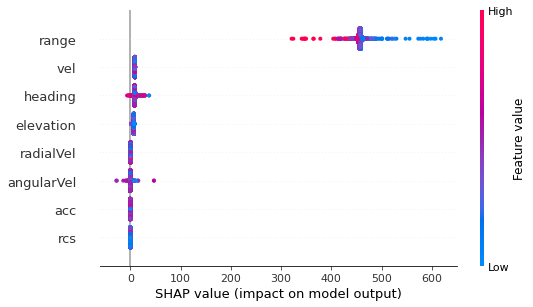

In [48]:
shap.summary_plot(inversed_shap_values,x_test_2d)

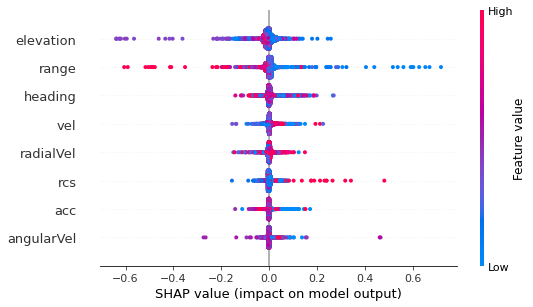

In [49]:
shap.summary_plot(shap_values_2D,x_test_2d)

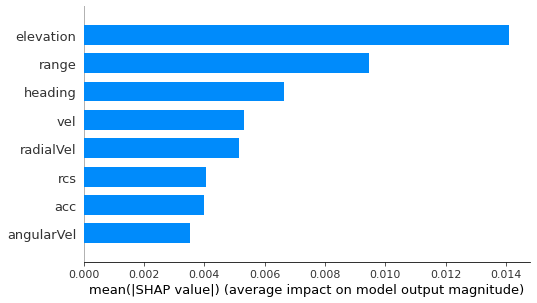

In [50]:
shap.summary_plot(shap_values_2D,x_test_2d,plot_type='bar')

In [51]:
len_test_set=X_test_2D.shape[0]
len_test_set

8000

-------------time step 0-------------


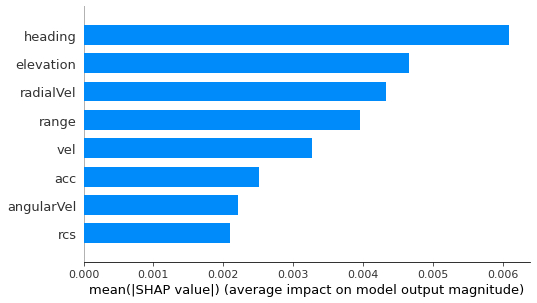

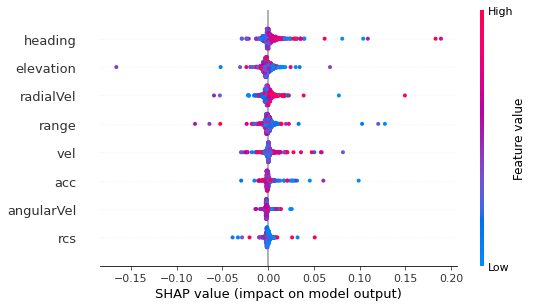

-------------time step 1-------------


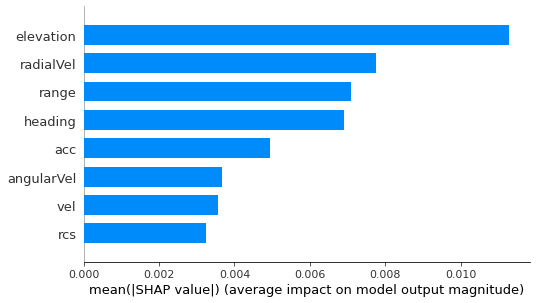

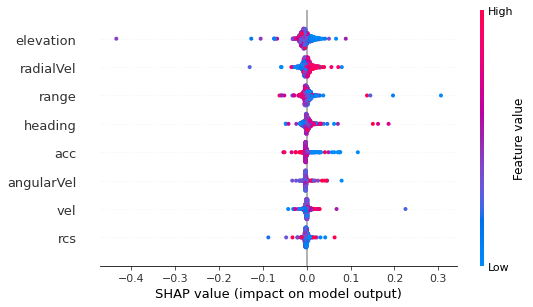

-------------time step 2-------------


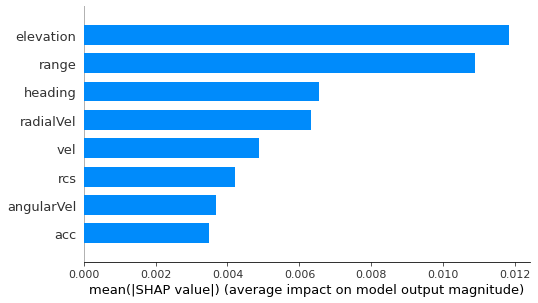

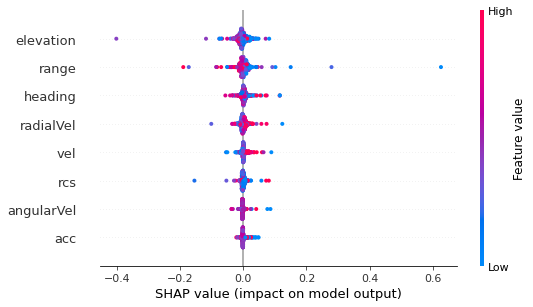

-------------time step 3-------------


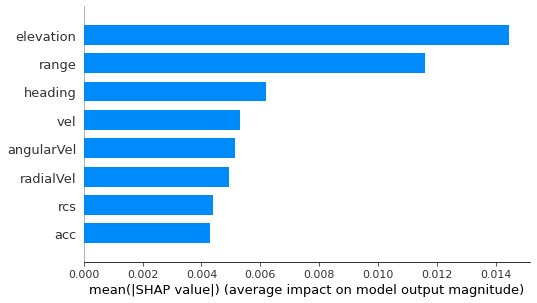

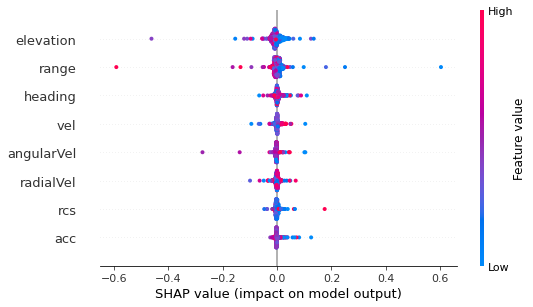

-------------time step 4-------------


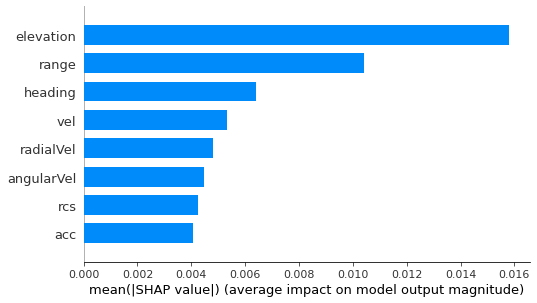

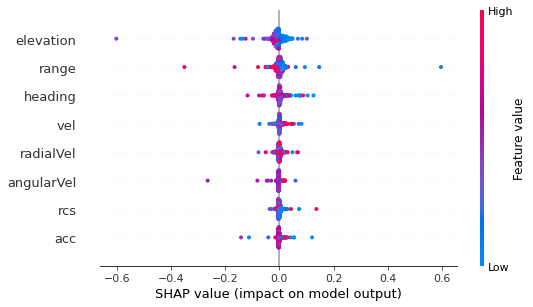

-------------time step 5-------------


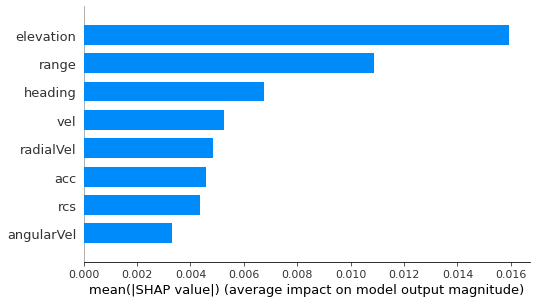

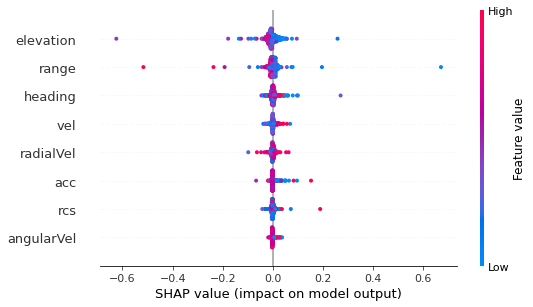

-------------time step 6-------------


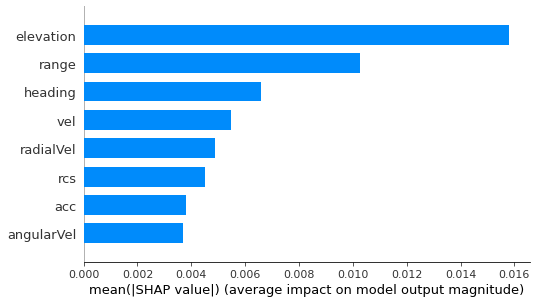

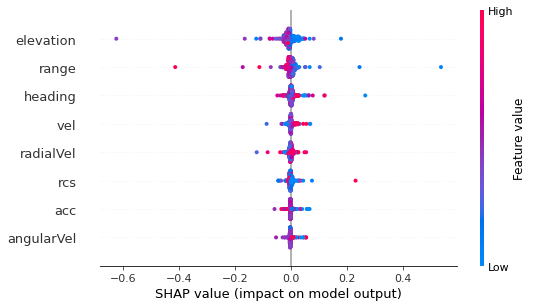

-------------time step 7-------------


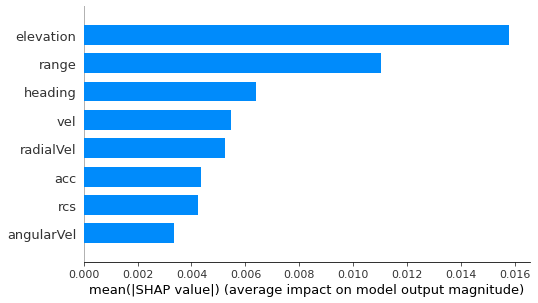

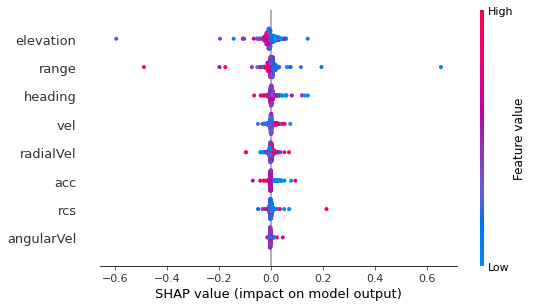

-------------time step 8-------------


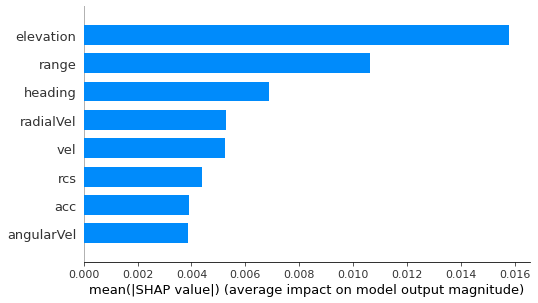

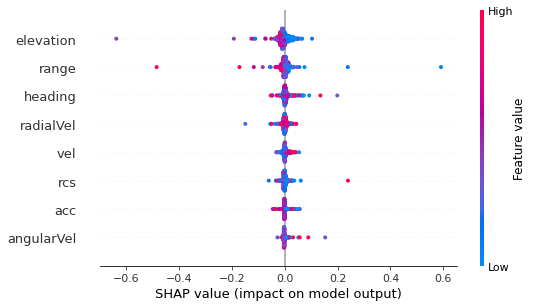

-------------time step 9-------------


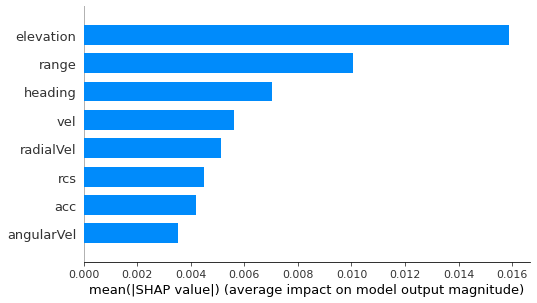

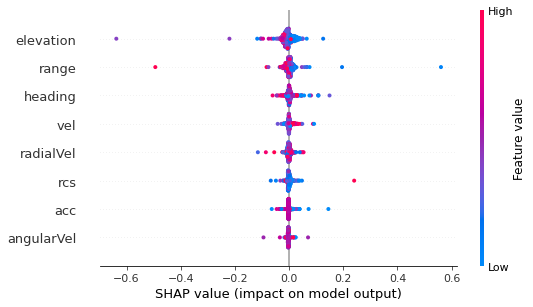

-------------time step 10-------------


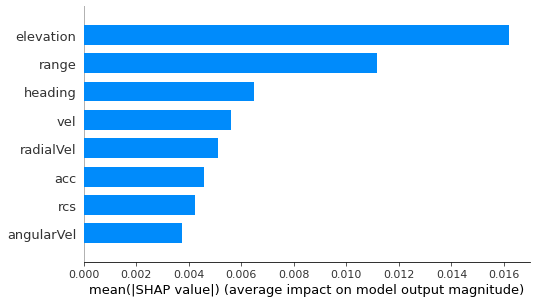

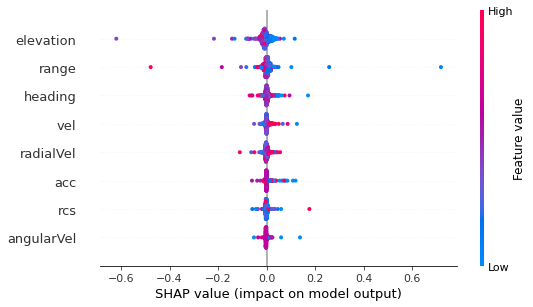

-------------time step 11-------------


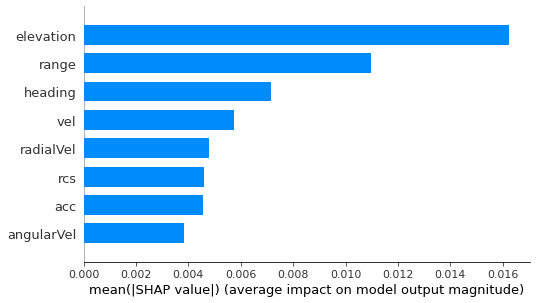

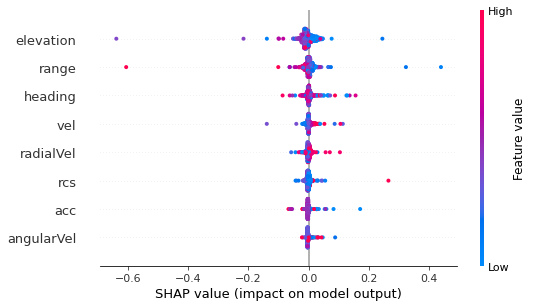

-------------time step 12-------------


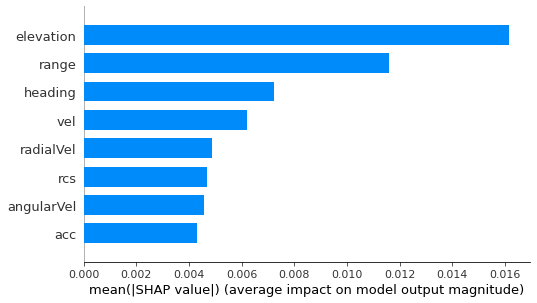

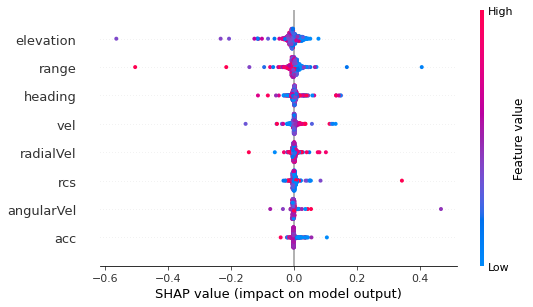

-------------time step 13-------------


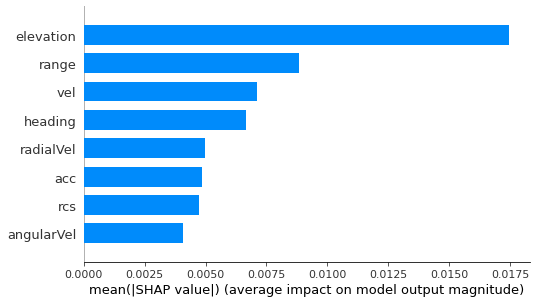

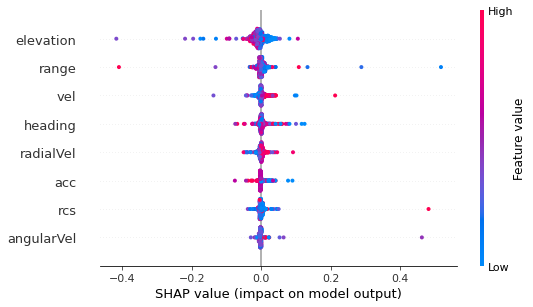

-------------time step 14-------------


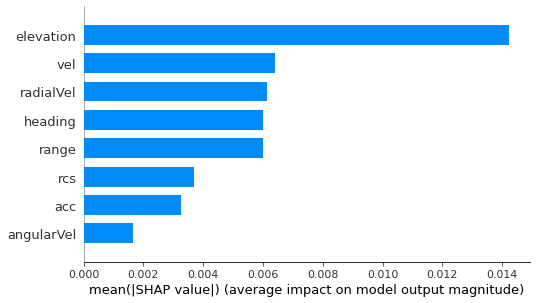

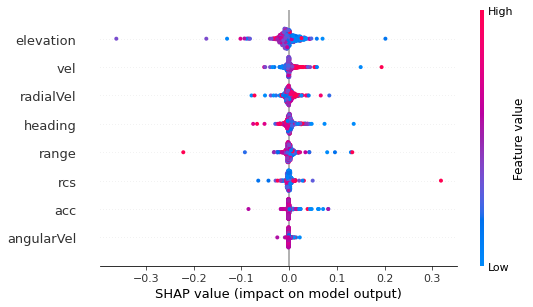

-------------time step 15-------------


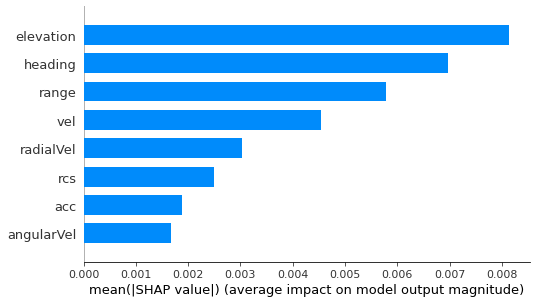

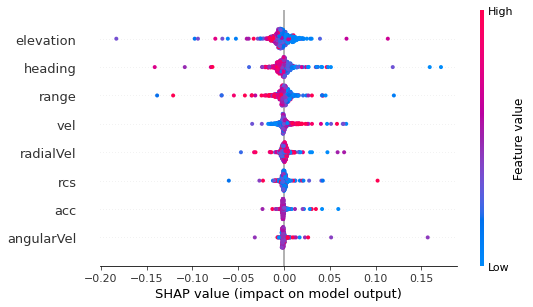

In [52]:
##SHAP for each time step
NUM_STEPS=window_size
NUM_FEATURES=len(feature_columns)

for step in range(NUM_STEPS):
    indice=[i for i in list(range(len_test_set)) if i%NUM_STEPS==step]
    shap_values_2D_step=shap_values_2D[indice]
    x_test_2d_step=x_test_2d.iloc[indice]
    print(f"-------------time step {step}-------------")
    shap.summary_plot(shap_values_2D_step,x_test_2d_step,plot_type='bar')
    shap.summary_plot(shap_values_2D_step,x_test_2d_step)